# Histograms and Density Plots

In this notebook we will look at the [NYCFlights13 dataset](https://cran.r-project.org/web/packages/nycflights13/nycflights13.pdf), which contains information on over 300,000 planes departing NYC airports in 2013. We will focus on visualizing the distribution of arrival delays given in minutes. 

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.dpi'] = 200

import seaborn as sns

from IPython.core.pylabtools import figsize

## Data Import 

In [2]:
 # Read in data
flights = pd.read_csv('data/flights.csv')
carriers = pd.read_csv('data/by_carrier.csv')
airlines = pd.read_csv('data/airlines.csv')

flights = flights.merge(airlines, how = 'left', on = 'carrier')
flights = flights[['arr_delay', 'name']] 

# Filter flight delays between -60 and 120 minutes
flights = flights[flights['arr_delay'].between(-60, 120)]
flights.head(10)

,arr_delay,name
0,11.0,United Air Lines Inc.
1,20.0,United Air Lines Inc.
2,33.0,American Airlines Inc.
3,-18.0,JetBlue Airways
4,-25.0,Delta Air Lines Inc.
5,12.0,United Air Lines Inc.
6,19.0,JetBlue Airways
7,-14.0,ExpressJet Airlines Inc.
8,-8.0,JetBlue Airways
9,8.0,American Airlines Inc.


In [3]:
flights.to_csv('data/formatted_flights.csv')

In [4]:
flights = pd.read_csv('data/formatted_flights.csv')
flights['arr_delay'].describe()

count    317113.000000
mean          1.297143
std          29.064401
min         -60.000000
25%         -17.000000
50%          -6.000000
75%          11.000000
max         120.000000
Name: arr_delay, dtype: float64

# Histogram of All Arrival Delays 

## Matplotlib

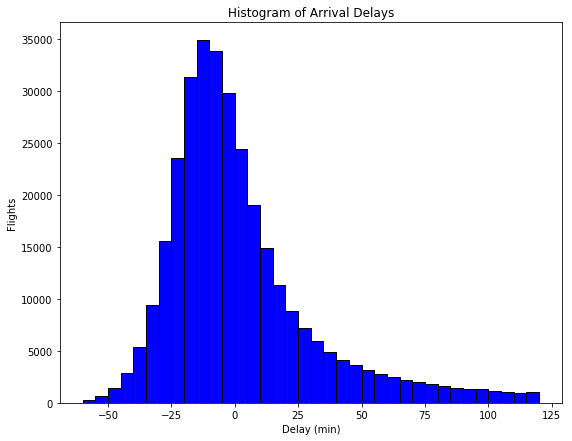

In [5]:
figsize(9, 7)

# Make the histogram using matplotlib, bins must be integet
plt.hist(flights['arr_delay'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)'); plt.ylabel('Flights');

## Seaborn

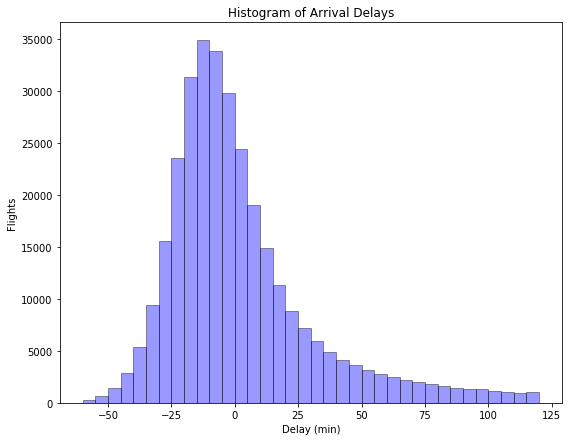

In [6]:
figsize(9, 7)

sns.distplot(flights['arr_delay'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)'); plt.ylabel('Flights');


## Histogram with Varying Binwidths

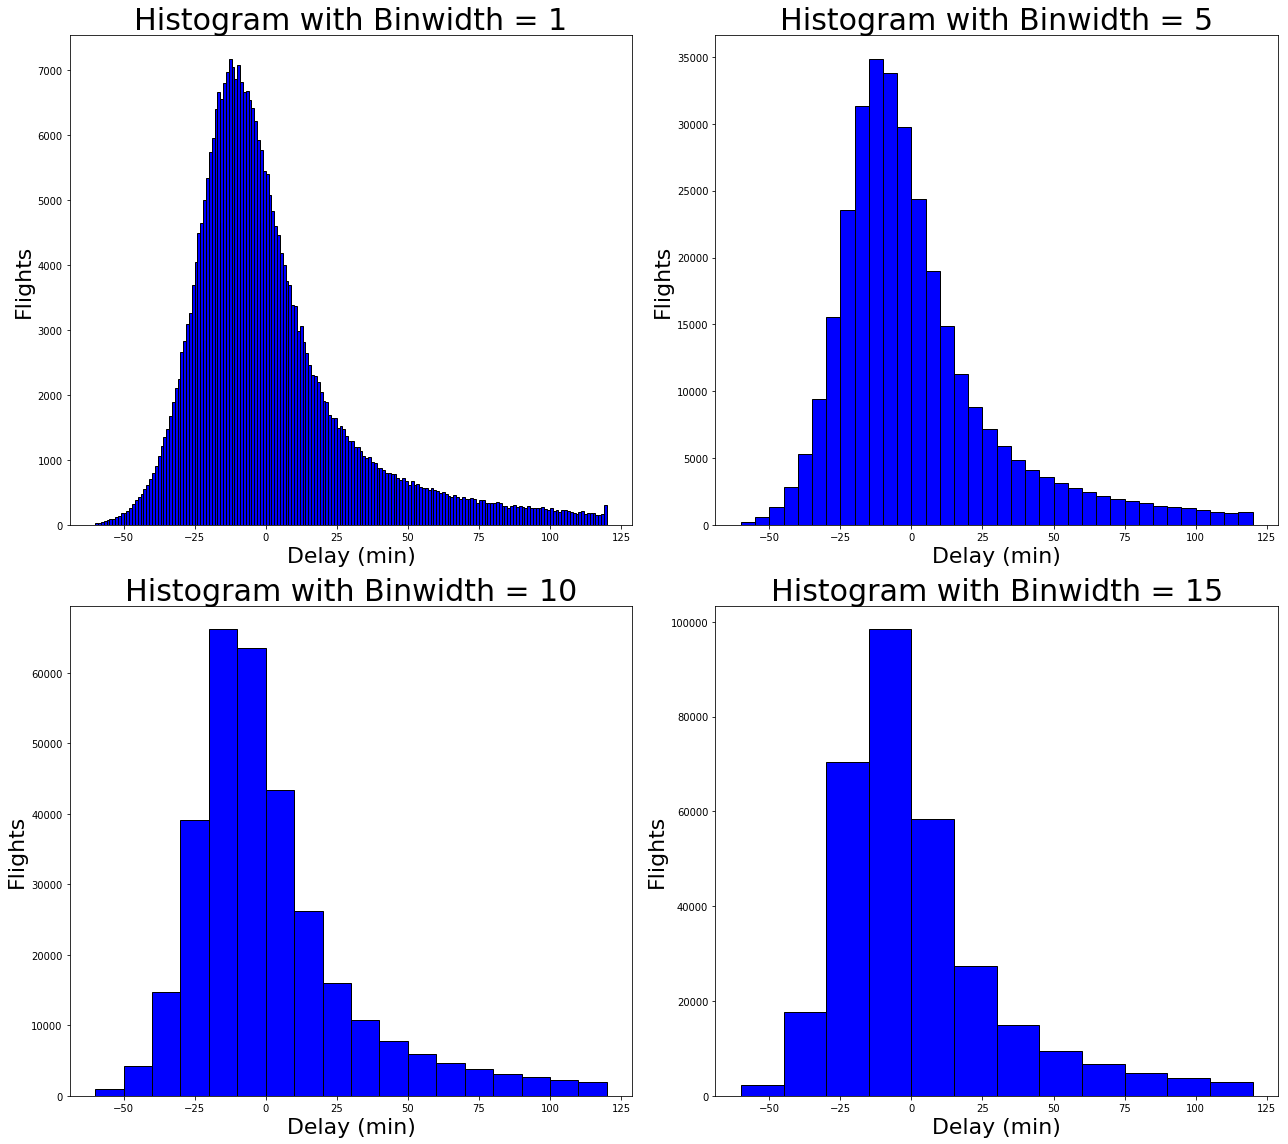

In [7]:
figsize(18, 16)

# Show 4 different binwidths
for i, binwidth in enumerate([1, 5, 10, 15]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(flights['arr_delay'], bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
    ax.set_xlabel('Delay (min)', size = 22)
    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

# Where Histograms Fail: Multiple Categories

Histograms work very well for display a single variable from one category (in this case the one category was all the flights). However, for displaying multiple categories, a histogram does not work well because the plots are obscured.

In [8]:
# Extract top five airlines with most flights
carrier_flights = pd.Series(flights.groupby('name')['name'].count())
carrier_flights = carrier_flights.sort_values(ascending=False)
top_five = carrier_flights.index[:5]

# Subset to the top 5 airlines
top_five_flights = flights[flights['name'].isin(top_five)]

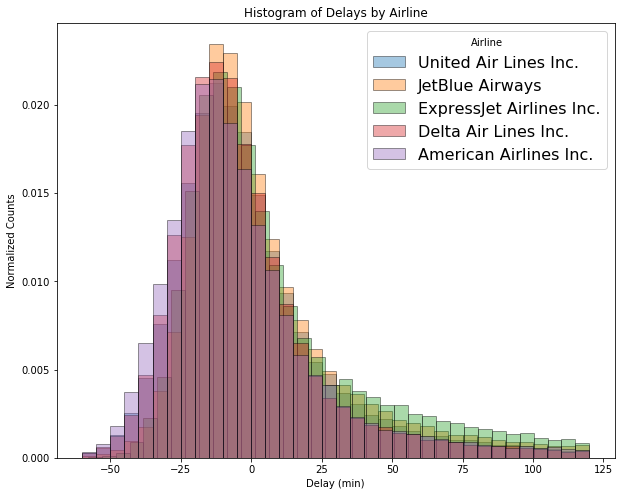

In [9]:
figsize(10, 8)

# Iterate through each of the five airlines
for airline in top_five:
    # Subset to the airline
    subset = top_five_flights[top_five_flights['name'] == airline]
    # Make a histogram with the airline
    sns.distplot(subset['arr_delay'], bins = int(180/5), 
                 label = airline, hist = True, kde = False, 
                 norm_hist=True, 
                 hist_kws = {'edgecolor': 'black'})
    
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Histogram of Delays by Airline'); plt.xlabel('Delay (min)'); plt.ylabel('Normalized Counts');

In [10]:
# Make a separate list for each airline
x1 = list(flights[flights['name'] == 'United Air Lines Inc.']['arr_delay'])
x2 = list(flights[flights['name'] == 'JetBlue Airways']['arr_delay'])
x3 = list(flights[flights['name'] == 'ExpressJet Airlines Inc.']['arr_delay'])
x4 = list(flights[flights['name'] == 'Delta Air Lines Inc.']['arr_delay'])
x5 = list(flights[flights['name'] == 'American Airlines Inc.']['arr_delay'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00']
names = ['United Air Lines Inc.', 'JetBlue Airways', 'ExpressJet Airlines Inc.',
         'Delta Air Lines Inc.', 'American Airlines Inc.']

## Solution 1: Side-by-Side Histograms

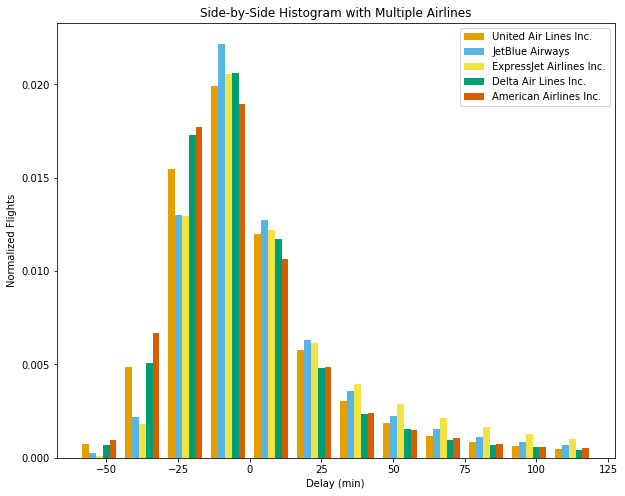

In [11]:
figsize(10, 8)

# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3, x4, x5], bins = int(180/15), normed=True,
         color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Delay (min)')
plt.ylabel('Normalized Flights')
plt.title('Side-by-Side Histogram with Multiple Airlines');

## Solution 2: Stacked Histograms

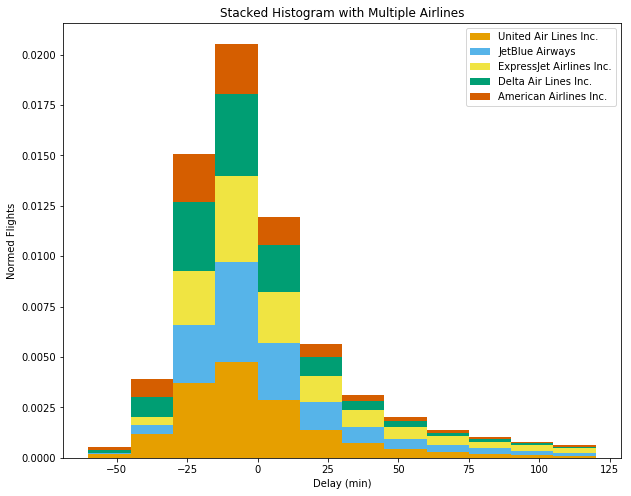

In [12]:
figsize(10, 8)
plt.hist([x1, x2, x3, x4, x5], bins = int(180/15), normed=True,
         stacked=True,
         color = colors, label=names)

plt.legend(); plt.xlabel('Delay (min)'); plt.ylabel('Normed Flights');
plt.title('Stacked Histogram with Multiple Airlines');

# Solution 3: Density Plots

A density plot uses a kernel (by default a Gaussian) at every data point to create a distribution and then sums the distribution at each location to create a single distribution.

![](images/KDEWIKI.png)

This produces a smoothed version of a histogram where the y-axis is in density. This density can be thought of as a probability of the data value corresponding to the value on the x-axis, but this can create issues because the density may be greater than one. I usually just think of it as _density_, a value used for comparison purposes only. 

## Density Plot of All Delays Using Seaborn

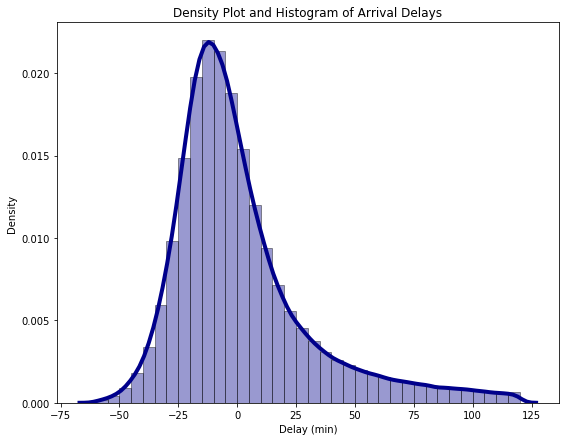

In [13]:
figsize(9, 7)

sns.distplot(flights['arr_delay'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

plt.title('Density Plot and Histogram of Arrival Delays'); 
plt.xlabel('Delay (min)'); plt.ylabel('Density');

# Density Plot with Varying Bandwidths

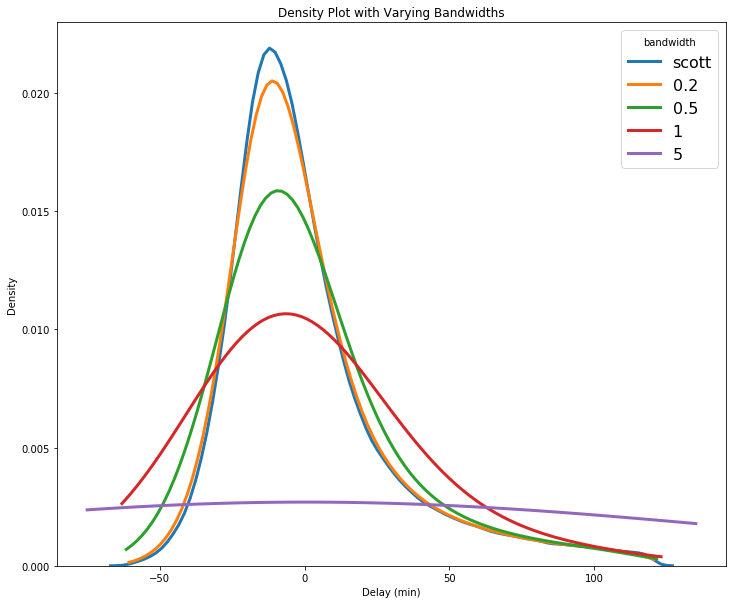

In [14]:
figsize(12, 10)

for bandwidth in ['scott', 0.2, 0.5, 1, 5]:
    sns.distplot(flights['arr_delay'], hist = False, kde = True, 
                 kde_kws={'bw': bandwidth, 'linewidth': 3},
                 label = bandwidth)
    
plt.legend(prop={'size': 16}, title = 'bandwidth')
plt.title('Density Plot with Varying Bandwidths'); 
plt.xlabel('Delay (min)'); plt.ylabel('Density');

## Different Kernels for the Density Plot

In [ ]:
for kernel in ['gau', 'cos', 'biw', 'epa', 'tri', 'triw']:
    sns.distplot(flights['arr_delay'], hist = False, kde = True, 
                 kde_kws={'kernel': kernel, 'linewidth': 3},
                 label = kernel)
    
plt.legend(prop={'size': 16}, title = 'Kernel')
plt.title('Density Plot with Different Kernels'); 
plt.xlabel('Delay (min)'); plt.ylabel('Density');

# Density Plot of Delays of Top Five

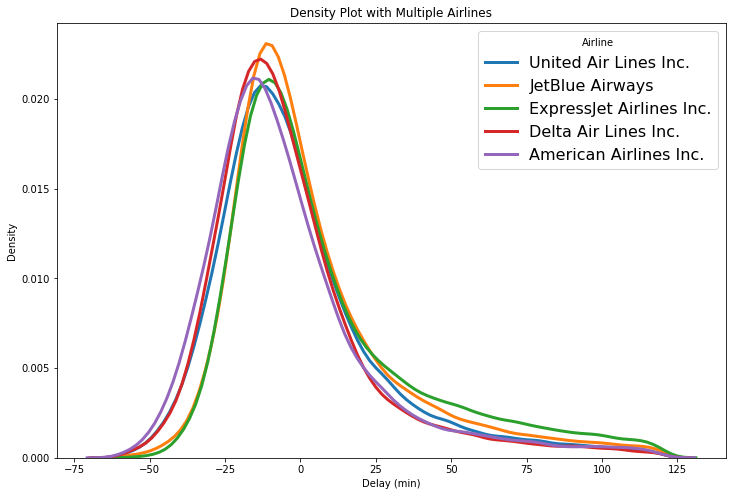

In [16]:
figsize(12, 8)

# List of five airlines to plot
airlines = ['United Air Lines Inc.', 'JetBlue Airways', 'ExpressJet Airlines Inc.',
         'Delta Air Lines Inc.', 'American Airlines Inc.']

# Iterate through the top five airlines
for airline in airlines:
    # Subset to the airline
    subset = flights[flights['name'] == airline]
    
    # Draw the density plot
    sns.distplot(subset['arr_delay'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = airline)
    
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot with Multiple Airlines'); 
plt.xlabel('Delay (min)')
plt.ylabel('Density');

## Shaded Density Plot

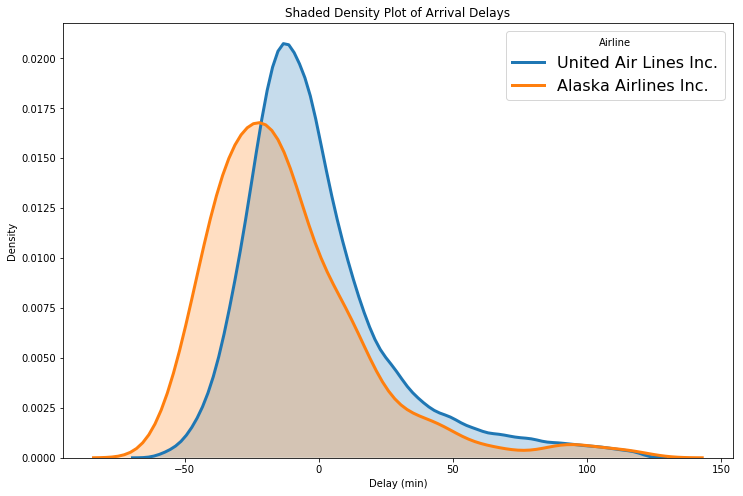

In [17]:
for airline in ['United Air Lines Inc.', 'Alaska Airlines Inc.']:
    subset = flights[flights['name'] == airline]
    
    sns.distplot(subset['arr_delay'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = airline)
    
plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Shaded Density Plot of Arrival Delays'); 
plt.xlabel('Delay (min)'); plt.ylabel('Density');

## Density with Rug Plot

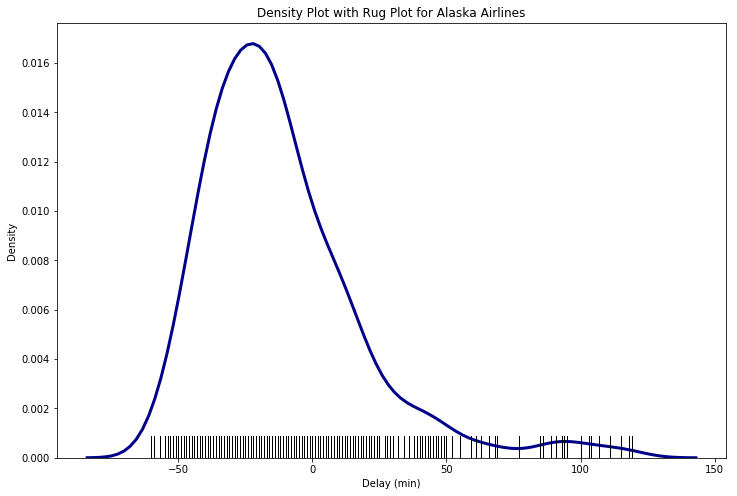

In [18]:
# Subset to Alaska Airlines
subset = flights[flights['name'] == 'Alaska Airlines Inc.']

# Density Plot with Rug Plot
sns.distplot(subset['arr_delay'], hist = False, kde = True, rug = True,
             color = 'darkblue', 
             kde_kws={'linewidth': 3},
             rug_kws={'color': 'black'})

# Plot formatting
plt.title('Density Plot with Rug Plot for Alaska Airlines');
plt.xlabel('Delay (min)'); plt.ylabel('Density');